# Лабораторная работа №1. 

Данная лабораторная работа состоит из нескольких блоков. В каждом блоке вам предлагается произвести некоторые манипуляции с данными и сделать некоторые выводы.
* Задавать вопросы можно и нужно.
* Списывать не нужно. Работы, которые были списаны обнуляются.
* Блоки выполняются последовательно и оцениваются отдельно.

__Вторая часть задания про градиентный бустинг и третья про SVM ждут вас в соседних ноутбуках.__

## Часть 1. Работа с моделями и ансамблями моделей в задачи классификации.

### 1. Чтение данных.
Воспользуемся [датасетом](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29), в котором описываются различные автомобили. Будем решать задачу многоклассовой ($k=4$) классификации.
Для удобства, датасет уже преобразован в удобный формат.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

np.random.seed(0)

dataset = pd.read_csv('car_data.csv', delimiter=',', header=None).values
data = dataset[:, 1:-1].astype(int)
target = dataset[:, -1]
print(data.shape, target.shape)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(data)
data = scaler.transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.35)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(846, 18) (846,)
(549, 18) (549,) (297, 18) (297,)


Для первичного анализа может быть полезна библиотека `pandas`. Преобразуем `train` выборку в `pd.DataFrame`.

In [2]:
X_train_pd = pd.DataFrame(X_train)

# First 15 rows of our dataset.
X_train_pd.head(15)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.082445,-0.301920,-0.259396,-0.207486,0.292525,-0.123383,-0.958282,0.905117,-0.996965,-0.206714,-1.039808,-0.899898,-0.482774,-1.264566,2.161133,-0.067140,2.283552,1.932585
1,1.983268,1.806342,1.326676,1.616001,0.292525,-0.775770,2.442738,-1.912888,2.477126,1.447652,2.912223,2.763994,1.976702,1.675609,-0.483592,-0.739337,-0.800711,-1.699181
2,1.497218,1.481994,1.199790,1.586108,0.673062,0.746467,1.600007,-1.400524,1.705106,1.723379,1.254920,1.591775,0.777708,-0.329056,-0.687032,-0.963402,-0.313722,0.721997
3,1.132680,-0.626268,0.057819,0.749097,0.165679,0.094079,0.185424,-0.375795,0.161066,-0.413510,0.330654,0.085445,-1.128387,-0.997277,0.126729,1.949450,1.309574,1.394546
4,0.646630,0.833298,0.375033,1.048030,0.292525,0.311542,0.486399,-0.760068,0.547076,0.758332,0.649367,0.436545,0.562503,-0.863633,1.143931,-0.179173,0.822585,0.721997
5,-0.568495,-0.626268,-0.449725,-0.207486,0.546217,-0.775770,-0.476722,0.264661,-0.610954,-0.827101,-0.434255,-0.497833,-0.636491,-0.061767,-0.890472,-1.411533,-0.151393,-0.085062
6,-1.540595,-0.301920,-0.893825,-1.313535,-0.595396,-0.123383,-0.597112,0.648935,-0.610954,-0.137782,-0.625482,-0.662057,-0.083109,1.408320,-0.076711,0.605056,-1.612359,-1.564671
7,0.525118,0.833298,0.501919,0.689311,0.165679,0.094079,0.245619,-0.503886,0.161066,0.482605,0.203170,0.181715,0.685477,-0.997277,0.737051,-1.299501,0.660256,0.721997
8,0.282093,-0.950615,-0.322839,-0.267272,0.038833,-0.123383,-0.867990,0.777026,-0.996965,0.137945,-0.880452,-0.826280,-1.558795,-1.398210,1.754252,-1.075435,1.958893,1.663566
9,-0.933032,-0.950615,-1.401368,-0.865137,-0.214858,-0.340845,-1.500038,1.801755,-1.382975,-0.964965,-1.549747,-1.290638,-1.036156,-1.531855,0.126729,-0.515271,1.796563,1.529056


Воспользовавшись методами `describe` и `info` можно получить полезную информацию о датасете.

In [3]:
X_train_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,-0.018479,0.000864,-0.011287,-0.008470,0.019194,0.010501,-0.019174,0.017112,-0.018932,0.006862,-0.011860,-0.019241,-0.001855,0.027816,0.016671,-0.023470,-0.011239,-0.022585
std,0.989283,0.994975,0.985520,1.018214,1.061017,1.075498,0.995969,0.994217,0.994119,1.000699,1.005958,0.996200,0.989348,1.031188,1.007141,0.978583,0.997460,0.983461
min,-2.512695,-1.761485,-2.416454,-1.911400,-1.863854,-1.428157,-1.650525,-1.912888,-1.382975,-2.067876,-1.740974,-1.386907,-2.019947,-1.799143,-1.297353,-1.411533,-2.099348,-1.968200
25%,-0.811520,-0.788441,-0.766939,-0.865137,-0.722241,-0.558308,-0.687405,-1.016250,-0.610954,-0.758169,-0.689224,-0.701697,-0.759465,-0.596344,-0.687032,-0.739337,-0.800711,-0.757612
50%,-0.082445,-0.139746,-0.195953,-0.087913,-0.088012,-0.123383,-0.386429,0.264661,-0.224944,-0.137782,-0.370512,-0.441204,-0.052366,-0.061767,-0.076711,-0.179173,-0.151393,0.049447
75%,0.646630,0.671124,1.009462,0.778991,0.419371,0.311542,0.847569,0.648935,0.933086,0.827264,0.872465,0.781981,0.716221,0.472810,0.533610,0.605056,0.660256,0.721997
max,3.076880,2.130690,1.707334,4.904256,9.679114,10.097349,2.894201,2.314119,3.249146,2.757358,4.187071,3.273655,2.683802,8.357825,3.178335,3.181810,2.445881,2.067095


In [4]:
X_train_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 18 columns):
0     549 non-null float64
1     549 non-null float64
2     549 non-null float64
3     549 non-null float64
4     549 non-null float64
5     549 non-null float64
6     549 non-null float64
7     549 non-null float64
8     549 non-null float64
9     549 non-null float64
10    549 non-null float64
11    549 non-null float64
12    549 non-null float64
13    549 non-null float64
14    549 non-null float64
15    549 non-null float64
16    549 non-null float64
17    549 non-null float64
dtypes: float64(18)
memory usage: 77.3 KB


### 2. Работа с данными, построение модели, анализ ошибки.
Выполните следующие манипуляции с данными:

#### 2.0. Предобработка данных.
* Произведите необходимые (по вашему мнению) манипуляции с данными и объясните их.
#### Ответ: Данные отнормировал выше методом `StandardScaler`, далее буду уменьшать размерность с помощью рекурсивного отбора признаков `RFECV`, поскольку так как данные разнородные.

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline

#### 2.1. Базовая логистическая регрессия.
* Подберите оптимальные параметры логистической регресии с помощью кросс-валидации на train-датасете (е переусердствуйте с подбором, в данной работе не стоит задача найти самую оптимальную модель. Небольшого grid/random search'а хватит).

* Постройте график ROC-кривой для данного классификатора (`sklearn.metrics.roc_curve`), оцените точность классификации и f1-score. 

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l2', solver = 'saga', n_jobs = -1, multi_class = 'multinomial', verbose=5)
param_grid = {'C': np.exp(np.linspace(-3, 4, 40)), 'penalty': ['l1', 'l2']}
search_params = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1)
search_params.fit(data, target)

max_iter reached after 0 seconds


/Users/ilyabasharov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
/Users/ilyabasharov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial', n_jobs=-1,
                                          penalty='l2', random_state=None,
                                          solver='saga', tol=0.0001, verbose=5,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([4.9787...
       3.69763086e+00, 4.42459827e+00, 5.29449005e+00, 6.33540566e+00,
       7.58096898e+00, 9.07141450e+00, 1.08548869e+01, 1.29889963e+01,
       1.55426793e+01, 1.85984254e+01, 2.22549421e+01, 2.66303431e+01,
       3.18659634e+01, 3.81309253e+01, 4.56276011e+01, 5.45981500e+01]),
       

In [7]:
lr_best = LogisticRegression(C = search_params.best_params_['C'], 
                             penalty = search_params.best_params_['penalty'], 
                             solver = 'saga', max_iter = 100000, n_jobs = 1, 
                             multi_class = 'auto', verbose=5)
rfe = RFECV(lr_best, min_features_to_select = 12, cv = 5, n_jobs = -1)
y_score = rfe.fit(data, target).decision_function(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 939 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 943 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 943 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


In [8]:
from sklearn.metrics import f1_score, accuracy_score
prediction = rfe.predict(X_test)
print ("accuracy score is: ",accuracy_score(y_test, prediction), "\nf1 score: ", f1_score(y_test, prediction, 
                                                                                          labels=['bus', 'opel', 'saab', 'van'], 
                                                                                          average = None))

accuracy score is:  0.8080808080808081 
f1 score:  [0.95945946 0.65277778 0.67857143 0.97014925]


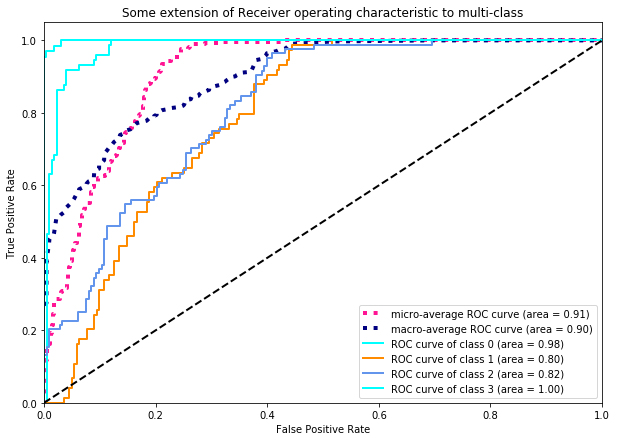

In [37]:
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def roc_plotting(y_test, y_score):
    lw = 2
    fpr, tpr, roc_auc, y_test_bin = dict(), dict(), dict(), label_binarize(y_test, classes=['bus', 'opel', 'saab', 'van'])

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= 4

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(4), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
roc_plotting(y_test, y_score)

#### 2.2. Зависимость объясненной дисперсии от числа главных компонент.
Воспользуемся методом главных компонент (PCA). 

Примените его к train-части данных.
Постройте график зависимости объясненной дисперсии (explained variance ratio) от количества главных компонент.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=18)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

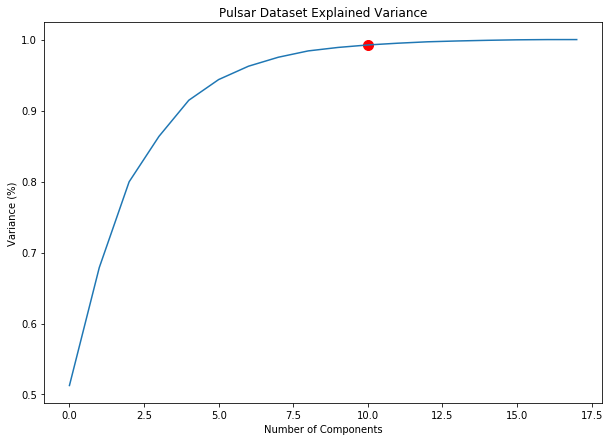

In [11]:
plt.figure(figsize=(10, 7))
variance_ratio = np.cumsum(pca.explained_variance_ratio_)
mask = 10
plt.plot(variance_ratio)
plt.scatter(mask, variance_ratio[mask], color='red', s=100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Pulsar Dataset Explained Variance')
plt.show()

#### 2.3. Преобразование с помощью PCA.

* Выберите определенное число компонент. Кратко опишите, чем обусловлен ваш выбор.
#### Oтвет: хотим, чтобы качество предсказания не поменялось, но размерность уменьшилась

* Используя эти главные компоненты, преобразуйте train и test выборки (используя методы `fit` и `transform`).

In [12]:
pca = PCA(n_components=mask)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.fit_transform(X_test)

#### 2.4. Логистическая регрессия над преобразованными данными.
* Подберите оптимальные параметры логистической регресии с помощью кросс-валидации на преобразованном train-датасете.

* Постройте график ROC-кривой для полученных классификаторов, оцените точность классификации и f1-score. 

In [13]:
lr = LogisticRegression(max_iter=10000, penalty = 'l1', solver = 'saga', n_jobs = -1, 
                        multi_class = 'auto', verbose=5, 
                        random_state = 0)
param_grid = {'C': np.exp(np.linspace(-3, 4, 50)), 'solver': ['saga'], 'penalty':['l2', 'l1'], 
             'multi_class': ['ovr', 'multinomial']}
search_params_lr = GridSearchCV(lr, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1)
search_params_lr.fit(pca_X_train, y_train)

convergence after 162 epochs took 0 seconds
convergence after 203 epochs took 0 seconds
convergence after 194 epochs took 0 seconds
convergence after 356 epochs took 0 seconds


/Users/ilyabasharov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=-1, penalty='l1',
                                          random_state=0, solver='saga',
                                          tol=0.0001, verbose=5,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([4.97870684e-02...
       8.52375646e+00, 9.83270708e+00, 1.13426667e+01, 1.30845032e+01,
       1.50938249e+01, 1.74117081e+01, 2.00855369e+01, 2.31699723e+01,
       2.67280690e+01, 3.08325648e+01, 3.55673674e+01, 4.10292700e+01,
       4.73299296e+01, 5.45981500e+01]),
                         'multi_class':

In [14]:
search_params_lr.best_params_

{'C': 1.7707949524351545,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'saga'}

In [15]:
prediction = search_params_lr.predict(pca_X_test)
print ("\naccuracy score is: ", accuracy_score(y_test, prediction), 
       "\nf1 score: ", f1_score(y_test, prediction, labels=['bus', 'opel', 'saab', 'van'], average = None))


accuracy score is:  0.531986531986532 
f1 score:  [0.72483221 0.39735099 0.38926174 0.62068966]


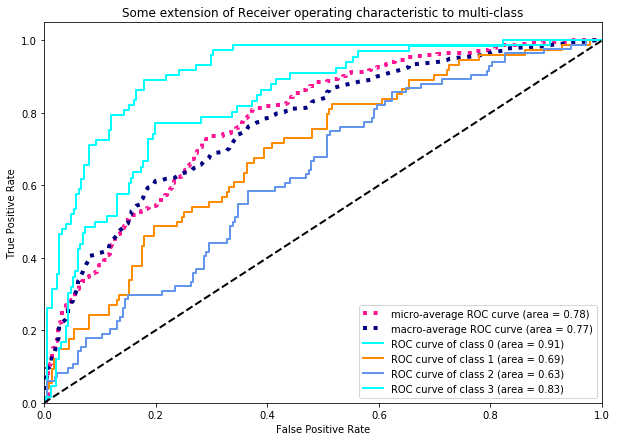

In [38]:
y_score = search_params_lr.decision_function(pca_X_test)
roc_plotting(y_test, y_score)

#### 2.5. Решающее дерево.
Рассмотрим поведение решающего дерева на исходных и преобразованных данных. Будем варьировать лишь один параметр - максимальную глубину дерева. 

* С помощью кросс-валидации подберите оптимальный параметр `max_depth` и оцените на исходных и преобразованных данных те же метрики, что и выше.

In [16]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0, max_features = 'auto')
param_grid = {'max_depth': [3,4,5,6,7,8,9,10], 'criterion': ['gini', 'entropy'], 
              'min_samples_split': [2,3,4,5,6,7,8,9,10]}
search_params = GridSearchCV(tree, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1)
search_params.fit(X_train, y_train)

/Users/ilyabasharov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
               

In [17]:
search_params.best_params_

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 5}

In [18]:
prediction = search_params.predict(X_test)
print ("accuracy score is: ", accuracy_score(y_test, prediction), 
       "\nf1 score: ", f1_score(y_test, prediction, labels=['bus', 'opel', 'saab', 'van'], average = None))

accuracy score is:  0.6801346801346801 
f1 score:  [0.86624204 0.54193548 0.4966443  0.82706767]


#### 2.6. Bagging.
Перейдем к ансамблям. 

Для построения ансамбля воспользуемся Bagging'ом с числом алгоритмов от 2 до 50. В качестве первого семейства базовых алгоримтов будем использовать линейные модели (т.е. логистическую регрессию), в качестве второго - решающие деревья. 

*Пояснение: Будем строить ансамбль только из моделей из одного семейства, т.е. логистическая регрессия не смешивается с решающими деревьями.*

Для этого можно сгенерировать с помощью метода bootstrap 50 подвыборок из `train` выборки (того же размера, что и исходная), обучить логистическую регрессию и решающее дерево с оптимальными параметрами из предыдущего пункта на каждой из подвыборок и затем усреднить предсказания k моделей.

*Hint: в sklearn может найтись подходящая функция, которая облегчит вам реализацию данного пункта.*

* Постройте график качества классификации и f1-score на `train` и `test` датасетах в зависимости от числа алгоритмов, вошедших в ансамбль.

* Проанализируйте график. Какое количество моделей стоит использовать? Как вы думаете, являются ли параметры решающего дерева, подобранные в предыдущем пункте оптимальными в данном случае?

#### Logistic Regression Bagging

In [19]:
from sklearn.ensemble import BaggingClassifier
import tqdm

num_trees = 50
array_num_trees = range(2, num_trees + 1)
f1_train, f1_test, acc_train, acc_test  = [], [], [], []

base_lr =  LogisticRegression(C = search_params_lr.best_params_['C'], 
                             penalty = search_params_lr.best_params_['penalty'], 
                             solver = search_params_lr.best_params_['solver'], 
                             max_iter = 1000000, n_jobs = -1, 
                             multi_class = search_params_lr.best_params_['multi_class'], verbose=5)

for num_tree in tqdm.tqdm_notebook(array_num_trees):
    model = BaggingClassifier(base_estimator = base_lr, 
                          n_estimators = num_tree, 
                          random_state = 0, n_jobs = -1)
    
    model.fit(X_train, y_train)
    f1_test.append(f1_score(y_test, model.predict(X_test), average='weighted'))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    f1_train.append(f1_score(y_train, model.predict(X_train), average='weighted'))
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))

In [20]:
def plotting(f1_train, f1_test, acc_train, acc_test, string):
    f1_test = np.array(f1_test)
    acc_test = np.array(acc_test)
    mask_f1 = max(f1_test) == f1_test
    mask_accuracy = max(acc_test) == acc_test
    index_acc = np.array(array_num_trees)[mask_accuracy]
    index_f1 = np.array(array_num_trees)[mask_f1]
    plt.figure(figsize=(10, 5))
    plt.plot(np.array(array_num_trees), acc_test, label="accuracy_score_test")
    plt.plot(index_acc[0], acc_test[mask_accuracy][0], color='red', marker='o')
    plt.plot(np.array(array_num_trees), f1_test, label="f1_score_test")
    plt.plot(index_f1[0], f1_test[mask_f1][0], color='red', marker='o')
    plt.plot(np.array(array_num_trees), acc_train, label="accuracy_score_train")
    plt.plot(np.array(array_num_trees), f1_train, label="f1_score_train")
    plt.ylabel('Score')
    plt.xlabel('Number of Estimators')
    plt.suptitle(string)
    plt.legend()
    plt.show()
    print("Оptimal Estimator for " + string + " is: ", index_acc[0])
    return index_acc[0]

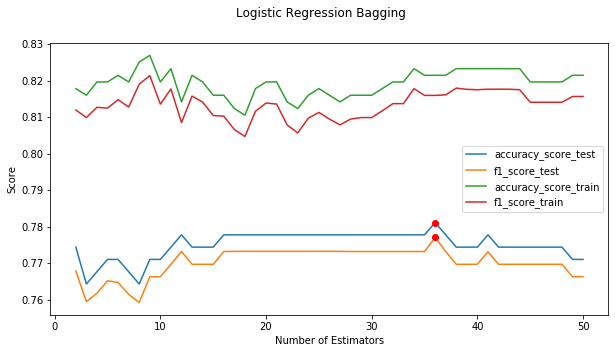

Оptimal Estimator for Logistic Regression Bagging is:  36


In [21]:
lr_index = plotting(f1_train, f1_test, acc_train, acc_test, 'Logistic Regression Bagging')

#### Tree bagging

In [22]:
f1_train, f1_test, acc_train, acc_test  = [], [], [], []

base_tree =  DecisionTreeClassifier(criterion = search_params.best_params_['criterion'],
                                   max_depth = search_params.best_params_['max_depth'],
                                   min_samples_split = search_params.best_params_['min_samples_split'])

for num_tree in tqdm.tqdm_notebook(array_num_trees):
    model = BaggingClassifier(base_estimator = base_tree, 
                          n_estimators = num_tree, 
                          random_state = 0, n_jobs = -1)
    
    model.fit(X_train, y_train)
    f1_test.append(f1_score(y_test, model.predict(X_test), average='weighted'))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    f1_train.append(f1_score(y_train, model.predict(X_train), average='weighted'))
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))

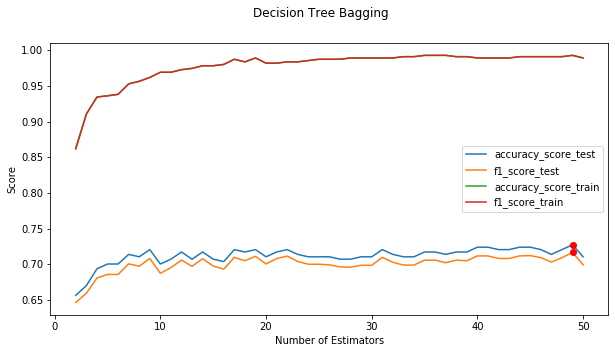

Оptimal Estimator for Decision Tree Bagging is:  49


In [23]:
tree_index = plotting(f1_train, f1_test, acc_train, acc_test, 'Decision Tree Bagging')

#### 2.7. Random Forest.
Теперь воспользуйтесь `sklearn`-реализацией алгоритма Random Forest. 

* Постройте аналогичные графики для него (изменяя число деревьев от 1 до 50). Остальные параметры можно оставить по умолчанию.

* Проанализируйте полученные результаты. Каким получилось оптимальное число деревьев. Как оно соотносится с оптимальным числом деревьев и линейных моделей в bagging'е из предыдущего пункта?

In [24]:
from sklearn.ensemble import RandomForestClassifier

f1_train, f1_test, acc_train, acc_test  = [], [], [], []

for num_tree in tqdm.tqdm_notebook(array_num_trees):
    rnd_forest_clf = RandomForestClassifier(n_estimators=num_tree, n_jobs=-1, max_depth = search_params.best_params_['max_depth'],
                                           min_samples_split = search_params.best_params_['min_samples_split'])
    rnd_forest_clf.fit(X_train, y_train)
    f1_test.append(f1_score(y_test, rnd_forest_clf.predict(X_test), average='weighted'))
    acc_test.append(accuracy_score(y_test, rnd_forest_clf.predict(X_test)))
    f1_train.append(f1_score(y_train, rnd_forest_clf.predict(X_train), average='weighted'))
    acc_train.append(accuracy_score(y_train, rnd_forest_clf.predict(X_train)))

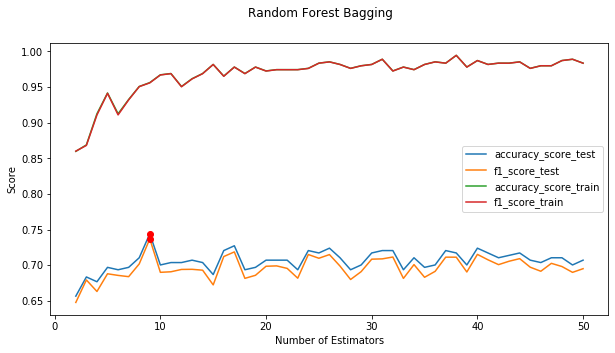

Оptimal Estimator for Random Forest Bagging is:  9


In [25]:
random_forest_index = plotting(f1_train, f1_test, acc_train, acc_test, 'Random Forest Bagging')

#### 2.8. Кривая обучения.
* Поделите обучающую выборку на 10 примерно равных частей. Обучите логистическую регрессию (с оптимальными параметрами), решающее дерево (аналогично), бэггинг над логистическими регрессиями и решающими деревьями (с выбранными параметрами) и RandomForest (из предыдущего пункта) на одной, двух, трех и т.д. частях.

* Постройти график f1-score и accuracy на `train` и `test` датасетах в зависимости от размера обучающей выборки.

* Проанализируйте полученный график. Можно ли сделать из него какие-либо выводы? Если да - кратко опишите их.

In [31]:
f1_train, f1_test, acc_train, acc_test  = [], [], [], []

lr_clf = LogisticRegression(C = search_params_lr.best_params_['C'], 
                             penalty = search_params_lr.best_params_['penalty'], 
                             solver = search_params_lr.best_params_['solver'], 
                             max_iter = 100000, n_jobs = -1, 
                             multi_class = search_params_lr.best_params_['multi_class'])

tree_clf = DecisionTreeClassifier(criterion = search_params.best_params_['criterion'],
                                   max_depth = search_params.best_params_['max_depth'],
                                   min_samples_split = search_params.best_params_['min_samples_split'])

bagging_lr = BaggingClassifier(base_estimator= LogisticRegression(C = search_params_lr.best_params_['C'], 
                                                                  penalty = search_params_lr.best_params_['penalty'], 
                                                                  solver = search_params_lr.best_params_['solver'], 
                                                                  max_iter = 100000, n_jobs = -1, 
                                                                  multi_class = search_params_lr.best_params_['multi_class']),
                               n_estimators=lr_index, n_jobs=-1, random_state=0)

bagging_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion = search_params.best_params_['criterion'],
                                                                       max_depth = search_params.best_params_['max_depth'],
                                                                       min_samples_split = search_params.best_params_['min_samples_split']),
                                 n_estimators=tree_index, n_jobs=-1, random_state=0)

rnd_forest_clf = RandomForestClassifier(n_estimators=random_forest_index, n_jobs=-1)

def add_predict(array, func, y_part, X_part, lr_clf, tree_clf, bagging_lr, bagging_tree, rnd_forest_clf):
    if func == "f1_score":
        array.append(f1_score(y_part, lr_clf.predict(X_part), average='weighted'))
        array.append(f1_score(y_part, tree_clf.predict(X_part), average='weighted'))
        array.append(f1_score(y_part, bagging_lr.predict(X_part), average='weighted'))
        array.append(f1_score(y_part, bagging_tree.predict(X_part), average='weighted'))
        array.append(f1_score(y_part, rnd_forest_clf.predict(X_part), average='weighted'))
    else:
        array.append(accuracy_score(y_part, lr_clf.predict(X_part)))
        array.append(accuracy_score(y_part, tree_clf.predict(X_part)))
        array.append(accuracy_score(y_part, bagging_lr.predict(X_part)))
        array.append(accuracy_score(y_part, bagging_tree.predict(X_part)))
        array.append(accuracy_score(y_part, rnd_forest_clf.predict(X_part)))

for k in tqdm.tqdm_notebook(range(1, 11)):
    lr_clf.fit(X_train[:55*k], y_train[:55*k])
    tree_clf.fit(X_train[:55*k], y_train[:55*k])
    bagging_lr.fit(X_train[:55*k], y_train[:55*k])
    bagging_tree.fit(X_train[:55*k], y_train[:55*k])
    rnd_forest_clf.fit(X_train[:55*k], y_train[:55*k])
    
    add_predict(f1_test, f1_score, y_test[:55*k], X_test[:55*k], 
                lr_clf, tree_clf, bagging_lr, bagging_tree, rnd_forest_clf)
    add_predict(acc_test, accuracy_score, y_test[:55*k], X_test[:55*k], 
                lr_clf, tree_clf, bagging_lr, bagging_tree, rnd_forest_clf)
    add_predict(acc_train, accuracy_score, y_train[:55*k], X_train[:55*k], 
                lr_clf, tree_clf, bagging_lr, bagging_tree, rnd_forest_clf)
    add_predict(f1_train, f1_score, y_train[:55*k], X_train[:55*k], 
                lr_clf, tree_clf, bagging_lr, bagging_tree, rnd_forest_clf)

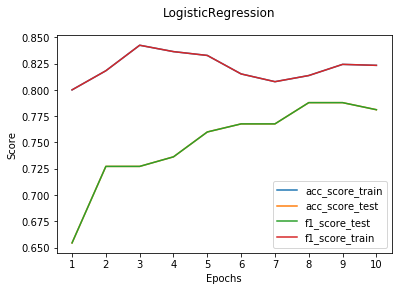

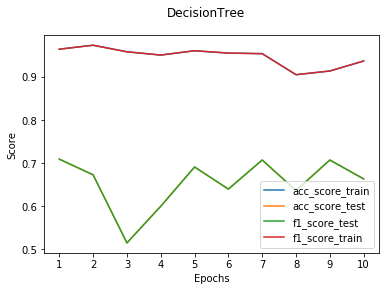

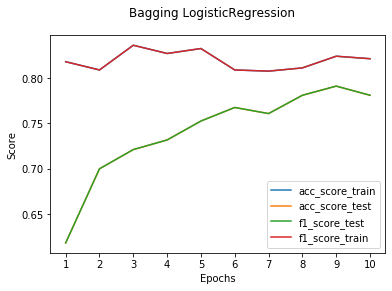

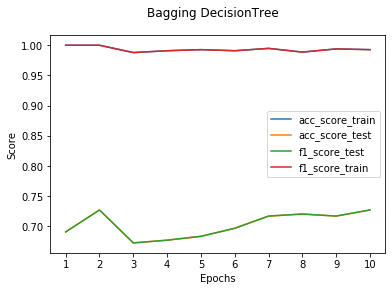

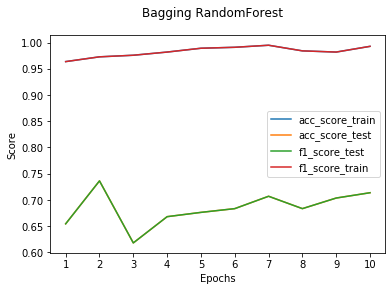

In [36]:
def result_plotting(acc_train, acc_test, f1_test, f1_train, 
                    index, summary):
    plt.plot(np.arange(1, 11), acc_train[index::5], label="acc_score_train")
    plt.plot(np.arange(1, 11), acc_test[index::5], label="acc_score_test")
    plt.plot(np.arange(1, 11), f1_test[index::5], label="f1_score_test")
    plt.plot(np.arange(1, 11), f1_train[index::5], label="f1_score_train")
    plt.ylabel('Score')
    plt.xlabel('Epochs')
    plt.suptitle(summary)
    plt.xticks(np.arange(1, 11, 1))
    plt.legend()
    plt.show()

result_plotting(acc_train, acc_test, f1_test, f1_train, 0, "LogisticRegression")
result_plotting(acc_train, acc_test, f1_test, f1_train, 1, "DecisionTree")
result_plotting(acc_train, acc_test, f1_test, f1_train, 2, "Bagging LogisticRegression")
result_plotting(acc_train, acc_test, f1_test, f1_train, 3, "Bagging DecisionTree")
result_plotting(acc_train, acc_test, f1_test, f1_train, 4, "Bagging RandomForest")

## Results:
Bagging - это алгоритм, предназначенный для улучшения стабильности и точности алгоритмов машинного обучения. Алгоритм также уменьшает дисперсию и помогает избежать переобучения. Он обычно применяется к методам обучения машин на основе деревьев решений.
Из графиков видно, что слова подтверждаются.

* Для деревянных моделей  Bagging algorithm также уменьшает дисперсию и помогает избежать переобучения - true.
* Для Logistic Regression особой разницы не видно, как минимум, не ухудшает предсказания.